In [52]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
import sys
sys.path.append("../")

In [54]:
import numpy as np
import pandas as pd
from dowhy import gcm, CausalModel
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score
from src.causal_graph import create_causal_graph
from src.utils import save_model, load_model

In [55]:
# read in training data
path_to_train_data = r"../data/data_prep/data_train.csv"
train_data = pd.read_csv(path_to_train_data)

In [56]:
train_data.forest_coverage.value_counts()

forest_coverage
cc>80        1402
60<cc<=80     346
40<cc<=60     150
20<cc<=40      57
cc<=20         16
Name: count, dtype: int64

In [57]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1971 entries, 0 to 1970
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       1971 non-null   int64  
 1   date             1971 non-null   object 
 2   loc_uncertainty  927 non-null    float64
 3   exposition       1971 non-null   object 
 4   elevation        1971 non-null   object 
 5   slope            1971 non-null   object 
 6   farmyard         1971 non-null   object 
 7   forestroad       1971 non-null   object 
 8   railway          1971 non-null   object 
 9   hikingtrail      1971 non-null   object 
 10  population       1971 non-null   object 
 11  forest_type      1971 non-null   object 
 12  forest_coverage  1971 non-null   object 
 13  ffmc             1971 non-null   float64
 14  fire             1971 non-null   object 
dtypes: float64(2), int64(1), object(12)
memory usage: 231.1+ KB


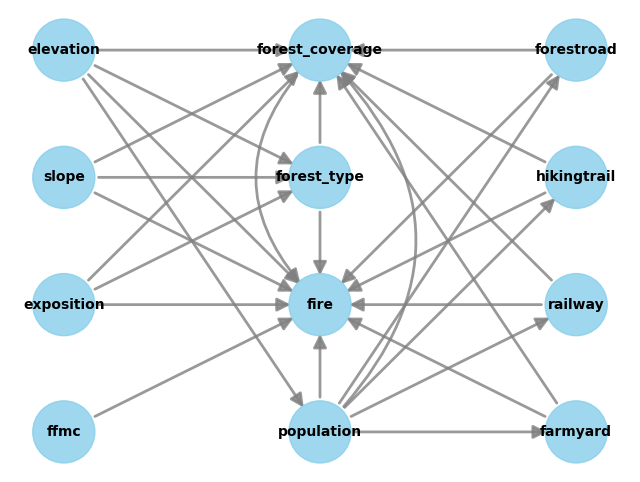

In [6]:
causal_graph = create_causal_graph()
model = CausalModel(
    data=train_data,
    treatment="forest_type",
    outcome="fire",
    graph=causal_graph)
model.view_model()

In [43]:
#data_dummy = pd.DataFrame({"Topograhpy": [], "Human Factors": [], "Forest Characteristics": [], "FFMC": [], "Fire": []})

#causal_graph_simple = create_simplified_causal_graph()
#model_simple = CausalModel(
#    graph=causal_graph_simple,
#    data=data_dummy, 
#    treatment="FFMC",
#    outcome="Fire")
#model_simple.view_model()

### Create the causal model

In [7]:
causal_graph = create_causal_graph()
causal_model = gcm.ProbabilisticCausalModel(causal_graph)

In [8]:
causal_mechanisms_summary = gcm.auto.assign_causal_mechanisms(causal_model, train_data)

In [9]:
gcm.fit(causal_model, train_data)

Fitting causal mechanism of node ffmc: 100%|██████████| 12/12 [00:02<00:00,  4.14it/s]          


In [10]:
summary_evaluation = gcm.evaluate_causal_model(causal_model, train_data, compare_mechanism_baselines=True)

Test permutations of given graph: 100%|██████████| 50/50 [01:31<00:00,  1.83s/it]


In [11]:
save_model(r"../models/model.pkl", causal_model, causal_mechanisms_summary, summary_evaluation)

In [48]:
print(causal_mechanisms_summary)

When using this auto assignment function, the given data is used to automatically assign a causal mechanism to each node. Note that causal mechanisms can also be customized and assigned manually.
The following types of causal mechanisms are considered for the automatic selection:

If root node:
An empirical distribution, i.e., the distribution is represented by randomly sampling from the provided data. This provides a flexible and non-parametric way to model the marginal distribution and is valid for all types of data modalities.

If non-root node and the data is continuous:
Additive Noise Models (ANM) of the form X_i = f(PA_i) + N_i, where PA_i are the parents of X_i and the unobserved noise N_i is assumed to be independent of PA_i.To select the best model for f, different regression models are evaluated and the model with the smallest mean squared error is selected.Note that minimizing the mean squared error here is equivalent to selecting the best choice of an ANM.

If non-root node

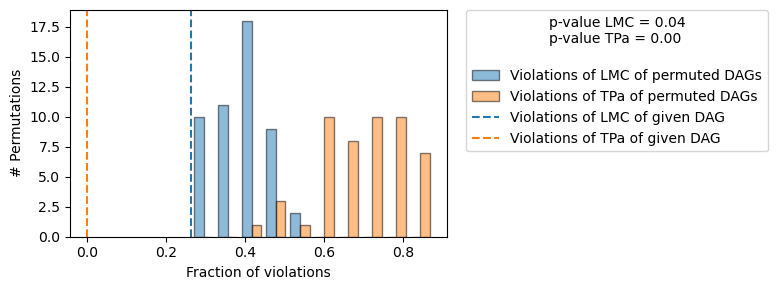

Evaluated the performance of the causal mechanisms and the invertibility assumption of the causal mechanisms and the overall average KL divergence between generated and observed distribution and the graph structure. The results are as follows:

==== Evaluation of Causal Mechanisms ====
The used evaluation metrics are:
- KL divergence (only for root-nodes): Evaluates the divergence between the generated and the observed distribution.
- Mean Squared Error (MSE): Evaluates the average squared differences between the observed values and the conditional expectation of the causal mechanisms.
- Normalized MSE (NMSE): The MSE normalized by the standard deviation for better comparison.
- R2 coefficient: Indicates how much variance is explained by the conditional expectations of the mechanisms. Note, however, that this can be misleading for nonlinear relationships.
- F1 score (only for categorical non-root nodes): The harmonic mean of the precision and recall indicating the goodness of the under

In [49]:
print(summary_evaluation)

### Causal Tasks

In [12]:
causal_model, causal_mechanisms_summary, summary_evaluation = load_model(r"../models/model.pkl")

#### ACE of forest cover, forest type & exposition 
The impact mediated over one of the other factors should be eliminated

In [13]:
forest_cover_classes = ["cc<=20", "20<cc<=40", "40<cc<=60", "60<cc<=80", "cc>80"]
exposition_classes = ["N", "NE", "E", "SE", "S", "SW", "W", "NW"]
forest_type_classes = ["coniferous non pine", "coniferous with mixed pine", "pine pure", 
                      "coniferous deciduous mixed with pine", "coniferous deciduous mixed non pine", "deciduous pure", "low and no vegetation"]

def construct_ate_dict(exposition_classes, ref_value):
    ate_dict = {"ref_value": ref_value, "ate": {}}  
    for region in exposition_classes:
        ate_dict["ate"][region] = {}
    return ate_dict

def get_ate_with_confidence_for_factor_classes(ate_dict: dict, factor_name: str, causal_model):
    for cl in ate_dict["ate"].keys():
        effect_median, effect_interval = gcm.confidence_intervals(
            gcm.bootstrap_sampling(gcm.average_causal_effect, 
                                causal_model, "fire", 
                                interventions_alternative={factor_name: lambda x: cl},
                                interventions_reference={factor_name: lambda x: ate_dict["ref_value"]}, 
                                num_samples_to_draw=1000))
        ate_dict["ate"][cl]["median"] = effect_median[0]
        ate_dict["ate"][cl]["interval"] = effect_interval[0]
    return ate_dict

def plot_ate_with_confidence(ate_data, path_to_fig: str):
    regions = list(ate_data['ate'].keys())
    ate_values = [ate_data['ate'][region]['median'] for region in regions]
    lower_bounds = [ate_data['ate'][region]['interval'][0] for region in regions]
    upper_bounds = [ate_data['ate'][region]['interval'][1] for region in regions]

    fig, ax = plt.subplots()
    y_pos = np.arange(len(regions))


    ax.errorbar(ate_values, y_pos, xerr=[np.array(ate_values) - np.array(lower_bounds), np.array(upper_bounds) - np.array(ate_values)],
                fmt='o', color='black', capsize=5, markersize=5)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(regions)
    ax.axvline(x=0, color='gray', linestyle='--')
    ax.set_xlabel('ATE')
    ax.set_title('Average Treatment Effect (ATE) with Confidence Intervals')
    plt.tight_layout()
    plt.savefig(path_to_fig)
    plt.show()


##### ACE of exposition

Estimating bootstrap interval...: 100%|██████████| 20/20 [00:03<00:00,  5.06it/s]


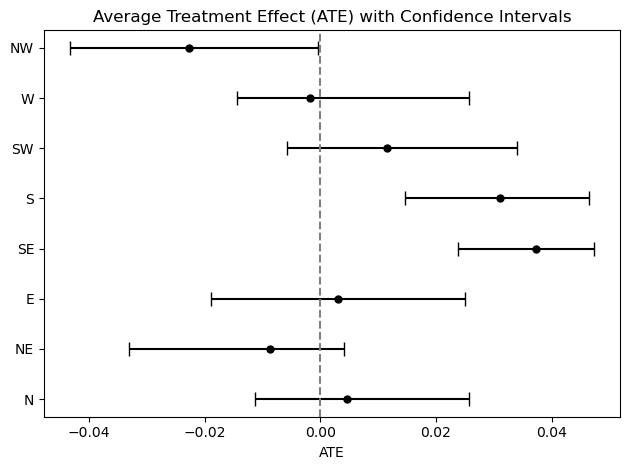

In [14]:
ate_dict_exposition = construct_ate_dict(exposition_classes, "E")

for exp in exposition_classes:

    effect_median, effect_interval = gcm.confidence_intervals(
                gcm.bootstrap_sampling(gcm.average_causal_effect, 
                                    causal_model, "fire", 
                                    interventions_alternative={'exposition': lambda x: exp, 
                                                        'forest_type': lambda x: "pine pure", 
                                                        'forest_coverage': lambda x: "40<cc<=60"},
                                    interventions_reference={'exposition': lambda x: "E", 
                                                    'forest_type': lambda x: "pine pure",
                                                    'forest_coverage': lambda x: "40<cc<=60"},
                                    observed_data=train_data))
    
    ate_dict_exposition["ate"][exp]["median"] = effect_median[0]
    ate_dict_exposition["ate"][exp]["interval"] = effect_interval[0]

plot_ate_with_confidence(ate_dict_exposition, r"../results/ate_exposition.png")

##### ACE for forest type

Estimating bootstrap interval...: 100%|██████████| 20/20 [00:04<00:00,  4.20it/s]


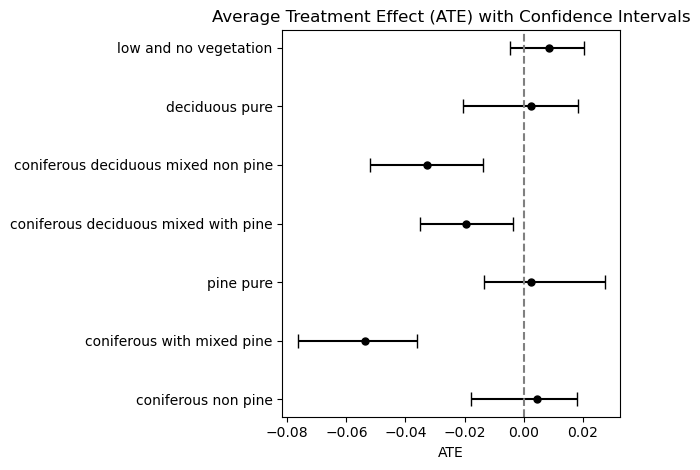

In [15]:
ate_dict_foresttype = construct_ate_dict(forest_type_classes, "coniferous non pine")

for ft in forest_type_classes:

    effect_median, effect_interval = gcm.confidence_intervals(
                gcm.bootstrap_sampling(gcm.average_causal_effect, 
                                    causal_model, "fire", 
                                    interventions_alternative={'forest_type': lambda x: ft, 
                                                        'forest_coverage': lambda x: "40<cc<=60"},
                                    interventions_reference={'forest_type': lambda x: "coniferous non pine", 
                                                    'forest_coverage': lambda x: "40<cc<=60"},
                                    observed_data=train_data))
    
    ate_dict_foresttype["ate"][ft]["median"] = effect_median[0]
    ate_dict_foresttype["ate"][ft]["interval"] = effect_interval[0]

plot_ate_with_confidence(ate_dict_foresttype, r"../results/ate_forest_type.png")

##### ACE for forest coverage

Estimating bootstrap interval...:   0%|          | 0/20 [00:00<?, ?it/s]

Estimating bootstrap interval...: 100%|██████████| 20/20 [00:02<00:00,  8.85it/s]


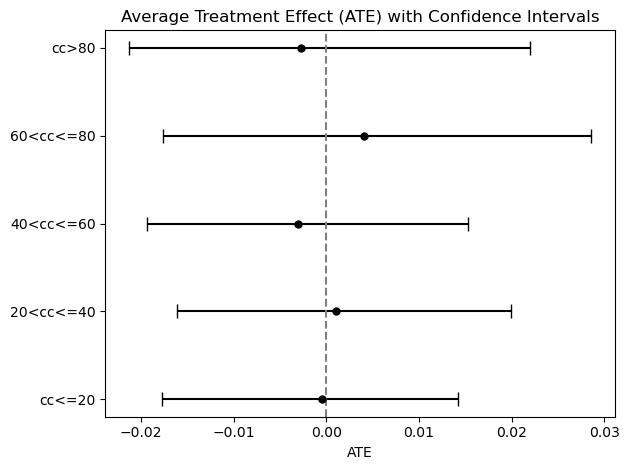

In [16]:
ate_dict_forestcoverage = construct_ate_dict(forest_cover_classes, "40<cc<=60")

for fcc in forest_cover_classes:

    effect_median, effect_interval = gcm.confidence_intervals(
                gcm.bootstrap_sampling(gcm.average_causal_effect, 
                                    causal_model, "fire", 
                                    interventions_alternative={'forest_coverage': lambda x: fcc},
                                    interventions_reference={'forest_coverage': lambda x: "40<cc<=60"},
                                    observed_data=train_data))
    
    ate_dict_forestcoverage["ate"][fcc]["median"] = effect_median[0]
    ate_dict_forestcoverage["ate"][fcc]["interval"] = effect_interval[0]

plot_ate_with_confidence(ate_dict_forestcoverage, r"../results/ate_forest_cover.png")

#### Estimating Effect: Quanitifying Arrow Strength

In [17]:
def plot_with_confidence(data, confidence_intervals):
    fig, ax = plt.subplots(figsize=(8, 6))

    x = np.arange(len(data))
    y = [data[key] for key in data]
    y_err = [confidence_intervals[key] for key in confidence_intervals]

    ax.bar(x, y, yerr=np.abs(np.array(y_err).T - np.array(y)), align='center', alpha=0.5, ecolor='black', capsize=5)
    ax.set_xticks(x)
    ax.set_xticklabels([key[0] for key in data.keys()], rotation=45)
    ax.set_ylabel('Values')
    ax.set_title('Values with Confidence Intervals')
    ax.yaxis.grid(True)

    plt.tight_layout()
    plt.savefig(r"../results/direct_causal_impact.png")
    plt.show()

In [18]:
strength_median, strength_intervals = gcm.confidence_intervals(
    gcm.bootstrap_sampling(gcm.arrow_strength,
                           causal_model,
                           target_node='fire', 
                           parent_samples=train_data))

print(strength_median)
print(strength_intervals)

Estimating bootstrap interval...: 100%|██████████| 20/20 [00:50<00:00,  2.51s/it]

{('elevation', 'fire'): 0.0010618820889398385, ('exposition', 'fire'): 0.0015997331063289997, ('farmyard', 'fire'): 6.702841815383361e-10, ('ffmc', 'fire'): 0.21671695362750182, ('forest_coverage', 'fire'): 5.081592665563572e-07, ('forest_type', 'fire'): 0.0018693357290132703, ('forestroad', 'fire'): 5.300859300878749e-07, ('hikingtrail', 'fire'): 0.021117691139490084, ('population', 'fire'): 0.13056643480385205, ('railway', 'fire'): 0.005471719693158754, ('slope', 'fire'): 5.8831806880565675e-06}
{('elevation', 'fire'): array([0.00106188, 0.00106188]), ('exposition', 'fire'): array([0.00159973, 0.00159973]), ('farmyard', 'fire'): array([6.70284182e-10, 6.70284182e-10]), ('ffmc', 'fire'): array([0.21671695, 0.21671695]), ('forest_coverage', 'fire'): array([5.08159267e-07, 5.08159267e-07]), ('forest_type', 'fire'): array([0.00186934, 0.00186934]), ('forestroad', 'fire'): array([5.3008593e-07, 5.3008593e-07]), ('hikingtrail', 'fire'): array([0.02111769, 0.02111769]), ('population', 'fire

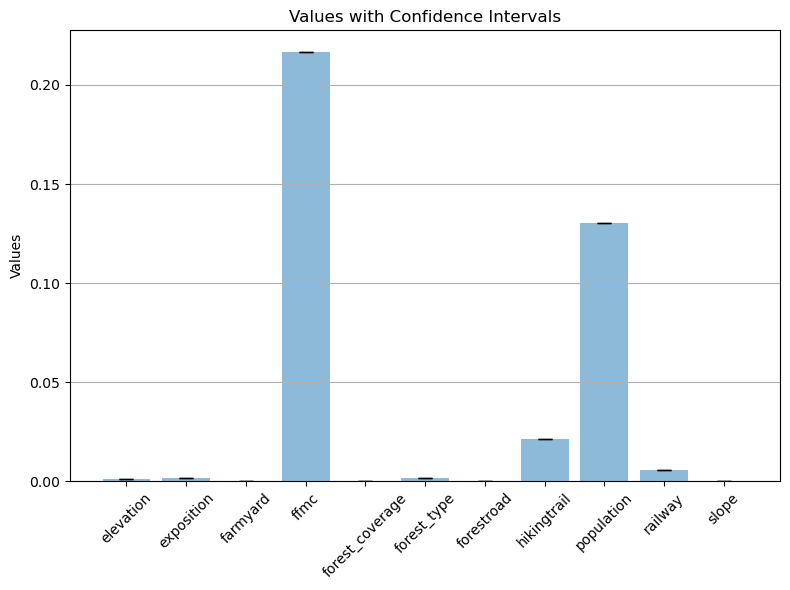

In [20]:
plot_with_confidence(strength_median, strength_intervals)

### Prediction 

In [19]:
def map_str_to_int(x):
    return 1 if x == "Yes" else 0

In [20]:
# read in test data
path_to_test_data = r"../data/data_prep/data_test.csv"
test_data = pd.read_csv(path_to_test_data)

In [39]:
scenario = {
    "ffmc": lambda x: 90,
    "elevation": lambda x: "800-1500",
    "exposition": lambda x: "S",
    "slope": lambda x: "10-20",
    "farmyard": lambda x: "No",
    "forestroad": lambda x: "No",
    "railway": lambda x: "Yes",
    "hikingtrail": lambda x: "Yes",
    "population": lambda x: "0",
    "forest_type": lambda x: "pine pure",
    "forest_coverage": lambda x: "cc>80"
}

samples = gcm.interventional_samples(causal_model,
                                        scenario,
                                        num_samples_to_draw=1000)


fire = samples.fire.apply(map_str_to_int)
print(np.mean(fire))
print(np.std(fire))

0.914
0.28036404905051593


In [22]:
def make_prediction(row):

    scenario = {
        "ffmc": lambda x: row.ffmc,
        "elevation": lambda x: row.elevation,
        "exposition": lambda x: row.exposition,
        "slope": lambda x: row.slope,
        "farmyard": lambda x: row.farmyard,
        "forestroad": lambda x: row.forestroad,
        "railway": lambda x: row.railway,
        "hikingtrail": lambda x: row.hikingtrail,
        "population": lambda x: row.population,
        "forest_type": lambda x: row.forest_type,
        "forest_coverage": lambda x: row.forest_coverage
    }

    samples = gcm.interventional_samples(causal_model,
                                         scenario,
                                         num_samples_to_draw=1000)
    
    fire = samples.fire.apply(map_str_to_int)
    return np.mean(fire)

In [50]:

y_pred = test_data.apply(lambda row: make_prediction(row), axis=1).values
y_pred_bin = np.where(np.array(y_pred) > 0.5, 1, 0)
y_true = test_data.fire.apply(map_str_to_int).values

print(accuracy_score(y_true, y_pred_bin))
print(f1_score(y_true, y_pred_bin))

0.817351598173516
0.8620689655172414


In [51]:
train_data

,Unnamed: 0,date,loc_uncertainty,exposition,elevation,slope,farmyard,forestroad,railway,hikingtrail,population,forest_type,forest_coverage,ffmc,fire
0,2211,2003-01-13,NaN,SW,800-1500,20-30,No,Yes,No,No,0,coniferous deciduous mixed non pine,cc>80,77.588692,No
1,1782,2003-02-06,NaN,NE,<500,<10%,No,Yes,No,Yes,0-50 P/km2,deciduous pure,cc>80,80.722717,No
2,1554,2003-02-07,NaN,W,<500,10-20,No,Yes,No,Yes,>1000 P/km2,deciduous pure,cc>80,80.781769,No
3,1654,2003-02-10,NaN,NE,<500,10-20,No,No,No,No,0,deciduous pure,cc>80,80.971992,No
4,1241,2003-02-13,NaN,S,500-800,20-30,No,No,No,No,0,coniferous non pine,cc>80,77.413132,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1966,158,2019-06-28,500.0,SW,500-800,30-40,No,No,No,Yes,>1000 P/km2,coniferous deciduous mixed non pine,cc>80,94.316063,Yes
1967,159,2019-06-28,100.0,SE,800-1500,30-40,No,Yes,No,No,0,low and no vegetation,60<cc<=80,91.131790,Yes
1968,1668,2019-06-28,NaN,E,500-800,10-20,No,Yes,No,No,>1000 P/km2,coniferous deciduous mixed non pine,cc>80,92.166908,No
1969,1456,2019-06-29,NaN,NE,<500,<10%,No,Yes,No,No,0,pine pure,40<cc<=60,90.790749,No
